In [ ]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel, DistilBertTokenizer
from PIL import Image
import os
import re
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Check if GPU is available
print("Running")
print(torch.cuda.is_available()) 

Running
False


## Multimodal Classification Model - Data Processing & Initial Training

In [ ]:
# 1. Combined Fusion Dataset Class
class MultimodalDataset(Dataset):
    def __init__(self, image_dir, text_dir, tokenizer, transform, max_len):
        # Store image and text directories, tokenizer, transform, and max_len
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len

        # Initialize lists to store image paths, labels, and texts
        self.image_paths = []
        self.labels = []
        self.texts = []

        # Create label map from class folders
        class_folders = sorted(os.listdir(self.image_dir))
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

        # Iterate over class folders
        for class_name in class_folders:
            class_path = os.path.join(self.image_dir, class_name)
            if os.path.isdir(class_path):
                file_names = os.listdir(class_path)
                for file_name in file_names:
                    file_path = os.path.join(class_path, file_name)
                    if os.path.isfile(file_path):
                        self.image_paths.append(file_path)
                        self.labels.append(self.label_map[class_name])

                        # Use file name as text label, remove digits and underscores and convert to lowercase
                        file_name_no_ext, _ = os.path.splitext(file_name)
                        text = file_name_no_ext.replace('_', ' ')
                        text_without_digits = re.sub(r'\d+', '', text)
                        self.texts.append(text_without_digits)

    def __len__(self):
        # Return number of samples in the dataset
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Retrieve image and apply transformations
        image_path = self.image_paths[idx]
        image = self.transform(Image.open(image_path).convert('RGB'))

        # Convert text label to input_ids and attention_mask
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        # retrieve numerical label
        label = self.labels[idx]

        # Return dictionary of image, tokenized text, and label
        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# 2. Multimodal Model Definition
class MultimodalClassifier(nn.Module):
    def __init__(self, image_model, text_model, num_classes=4, projection_dim=128):
        super(MultimodalClassifier, self).__init__()

        # Image Model Setup
        self.image_model = image_model
        self.image_model.classifier = nn.Identity()  # Remove classification layer
        image_feature_dim = 1280  # MobileNetV2 feature dimension

        # Text Model Setup
        self.text_model = text_model  # Directly use DistilBertModel
        text_feature_dim = 768  # DistilBERT hidden size

        # Projection layers
        self.image_projection = nn.Sequential(
            nn.Linear(image_feature_dim, projection_dim),
            nn.ReLU(),
            nn.BatchNorm1d(projection_dim)
        )

        self.text_projection = nn.Sequential(
            nn.Linear(text_feature_dim, projection_dim),
            nn.ReLU(),
            nn.BatchNorm1d(projection_dim)
        )

        # Final classifier to concatenate features
        self.classifier = nn.Sequential(
            nn.Linear(projection_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        # Image features
        img_features = self.image_model(image)
        img_features = self.image_projection(img_features)

        # Text features
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = text_outputs.last_hidden_state[:, 0, :]  # [CLS] token
        txt_features = self.text_projection(cls_output)

        # Combine features
        combined_features = torch.cat((img_features, txt_features), dim=1)

        # Final predictions from the classifier
        out = self.classifier(combined_features)
        return out

# 3. Data Preparation
# Define data directories
data_dir = r"/work/TALC/enel645_2025w/garbage_data"
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # Imagenet mean and std
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Imagenet mean and std
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225]),
])

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets for train, validation, and testing
train_dataset = MultimodalDataset(
    image_dir=train_dir,
    text_dir=train_dir,
    tokenizer=tokenizer,
    transform=train_transform,
    max_len=24
)

val_dataset = MultimodalDataset(
    image_dir=val_dir,
    text_dir=val_dir,
    tokenizer=tokenizer,
    transform=val_test_transform,
    max_len=24
)

test_dataset = MultimodalDataset(
    image_dir=test_dir,
    text_dir=test_dir,
    tokenizer=tokenizer,
    transform=val_test_transform,
    max_len=24
)

# Define data loaders for batching and shuffling
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Dictionary for easy access
dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}

# 4. Model Initialization
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize pre-trained MobileNetV2
mobile_net = models.mobilenet_v2(pretrained=True)
for param in mobile_net.parameters():
    param.requires_grad = False
mobile_net.classifier = nn.Identity()  # Remove classification layer

# Initialize pre-trained DistilBERT
distil_bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
for param in distil_bert.parameters():
    param.requires_grad = False

# Initialize Multimodal Classifier
model = MultimodalClassifier(
    image_model=mobile_net,
    text_model=distil_bert,
    num_classes=4,
    projection_dim=128
)

model = model.to(device)

# keep freezing projection except classifier layers
for param in model.image_projection.parameters():
    param.requires_grad = False

for param in model.text_projection.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=2e-4
)

# 5. Define Training and Evaluation Functions
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=10):
    best_acc = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)
        
        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for batch in dataloaders[phase]:
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(images, input_ids, attention_mask)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    # Backward pass and optimization only in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                torch.save(best_model_wts, "best_multimodal_model.pth")
        
        print()
    
    print(f"Best Validation Accuracy: {best_acc:.4f}")
    
    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    return model

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
    total_loss = running_loss / len(dataloader.dataset)
    total_acc = running_corrects.double() / len(dataloader.dataset)
    
    print(f"Evaluation Loss: {total_loss:.4f} Acc: {total_acc:.4f}")
    return total_loss, total_acc

def predict(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloaders["test"]:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

# 6. Execute the Training Loop
num_epochs = 10

# Train the model
trained_model = train_model(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

# 7. Testing the Model
# Load the best model
trained_model.load_state_dict(torch.load("best_multimodal_model.pth"))

# Generate predictions
test_preds, test_labels = predict(trained_model, dataloaders["test"], device)

# Calculate Accuracy
test_accuracy = (test_preds == test_labels).sum() / len(test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=train_dataset.label_map.keys(),
            yticklabels=train_dataset.label_map.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Multimodal Dataset for Image-Text Classification  

In [ ]:
# MultiModal Dataset
class MultimodalDataset(Dataset):
    def __init__(self, image_dir, text_dir, tokenizer, transform, max_len):
        self.image_dir = image_dir
        self.text_dir = text_dir
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_len

        self.image_paths = []
        self.labels = []
        self.texts = []
        class_folders = sorted(os.listdir(self.image_dir))
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}

        for class_name in class_folders:
            class_path = os.path.join(self.image_dir, class_name)
            if os.path.isdir(class_path):
                file_names = os.listdir(class_path)
                for file_name in file_names:
                    file_path = os.path.join(class_path, file_name)
                    if os.path.isfile(file_path):
                        self.image_paths.append(file_path)
                        self.labels.append(self.label_map[class_name])

                        file_name_no_ext, _ = os.path.splitext(file_name)
                        text = file_name_no_ext.replace('_', ' ')
                        text_without_digits = re.sub(r'\d+', '', text)
                        self.texts.append(text_without_digits)

    def __len__(self):
        # Return total samples
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = self.transform(Image.open(image_path).convert('RGB'))

        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        label = self.labels[idx]

        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [3]:
# 2. Multimodal Model Definition
class MultimodalClassifier(nn.Module):
    def __init__(self, image_model, text_model, num_classes=4, projection_dim=128):
        super(MultimodalClassifier, self).__init__()

        # Image Model
        self.image_model = image_model
        self.image_model.classifier = nn.Identity()  # Remove classification layer
        image_feature_dim = 1280  # MobileNetV2 feature dimension

        # Text Model
        self.text_model = text_model  # Directly use DistilBertModel
        text_feature_dim = 768  # DistilBERT hidden size

        # Projection layers
        self.image_projection = nn.Sequential(
            nn.Linear(image_feature_dim, projection_dim),
            nn.ReLU(),
            nn.BatchNorm1d(projection_dim)
        )

        self.text_projection = nn.Sequential(
            nn.Linear(text_feature_dim, projection_dim),
            nn.ReLU(),
            nn.BatchNorm1d(projection_dim)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(projection_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        # Image features
        img_features = self.image_model(image)
        img_features = self.image_projection(img_features)

        # Text features
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = text_outputs.last_hidden_state[:, 0, :]  # [CLS] token
        txt_features = self.text_projection(cls_output)

        # Concatenate features
        combined_features = torch.cat((img_features, txt_features), dim=1)

        # Classifier
        out = self.classifier(combined_features)
        return out

In [4]:
def unfreeze_mobilenet_layers(model, num_layers_to_unfreeze=2):
    """
    Unfreezes the last `num_layers_to_unfreeze` layers of MobileNetV2.
    
    Args:
        model (MultimodalClassifier): The multimodal model containing MobileNetV2.
        num_layers_to_unfreeze (int): Number of layers from the end to unfreeze.
    """
    # MobileNetV2 features are in model.image_model.features
    for child in model.image_model.features[-num_layers_to_unfreeze:]:
        for param in child.parameters():
            param.requires_grad = True

In [5]:
def unfreeze_distilbert_layers(model, num_layers_to_unfreeze=2):
    """
    Unfreezes the last `num_layers_to_unfreeze` transformer layers of DistilBERT.
    
    Args:
        model (MultimodalClassifier): The multimodal model containing DistilBERT.
        num_layers_to_unfreeze (int): Number of transformer layers from the end to unfreeze.
    """
    # DistilBERT has a transformer attribute with 12 transformer layers
    for layer in model.text_model.transformer.layer[-num_layers_to_unfreeze:]:
        for param in layer.parameters():
            param.requires_grad = True

In [6]:
def main():
    # 1. Data Preparation
    data_dir = r"/work/TALC/enel645_2025w/garbage_data"
    train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
    val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
    test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")
    
    # Define image transformations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),  # Rotate images by ±15 degrees
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225]),
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225]),
    ])
    
    # Initialize tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    
    # Create datasets
    train_dataset = MultimodalDataset(
        image_dir=train_dir,
        text_dir=train_dir,  # Assuming structured similarly
        tokenizer=tokenizer,
        transform=train_transform,
        max_len=24
    )
    
    val_dataset = MultimodalDataset(
        image_dir=val_dir,
        text_dir=val_dir,
        tokenizer=tokenizer,
        transform=val_test_transform,
        max_len=24
    )
    
    test_dataset = MultimodalDataset(
        image_dir=test_dir,
        text_dir=test_dir,
        tokenizer=tokenizer,
        transform=val_test_transform,
        max_len=24
    )
    
    # Define data loaders
    batch_size = 32
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader
    }
    
    # 2. Model Initialization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize pre-trained MobileNetV2
    mobile_net = models.mobilenet_v2(pretrained=True)
    for param in mobile_net.parameters():
        param.requires_grad = False
    mobile_net.classifier = nn.Identity()  # Remove classification layer
    
    # Initialize pre-trained DistilBERT
    distil_bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
    for param in distil_bert.parameters():
        param.requires_grad = False
    
    # Initialize Multimodal Classifier
    model = MultimodalClassifier(
        image_model=mobile_net,
        text_model=distil_bert,
        num_classes=4,
        projection_dim=128
    )
    
    model = model.to(device)
    
    # 3. Load the Best Initial Model Weights
    model.load_state_dict(torch.load("best_multimodal_model.pth", map_location=torch.device('cpu')))
    
    # 4. Unfreeze Specific Layers for Fine-Tuning
    unfreeze_mobilenet_layers(model, num_layers_to_unfreeze=2)
    unfreeze_distilbert_layers(model, num_layers_to_unfreeze=2)
    
    # 5. Define Parameter Groups with Differential Learning Rates
    optimizer = optim.Adam([
        {'params': model.image_projection.parameters(), 'lr': 1e-4},
        {'params': model.text_projection.parameters(), 'lr': 1e-4},
        {'params': model.classifier.parameters(), 'lr': 1e-4},
        # Unfrozen MobileNetV2 layers
        {'params': model.image_model.features[-2:].parameters(), 'lr': 1e-5},
        # Unfrozen DistilBERT transformer layers
        {'params': model.text_model.transformer.layer[-2:].parameters(), 'lr': 1e-5}
    ])
    
    # 6. Define Loss Function
    criterion = nn.CrossEntropyLoss()
    
    # 7. Fine-Tuning Training Loop
    def fine_tune_model(model, dataloaders, criterion, optimizer, device, num_epochs=3):
        best_acc = 0.0
        best_model_wts = None
    
        for epoch in range(num_epochs):
            print(f"Fine-Tuning Epoch {epoch + 1}/{num_epochs}")
            print("-" * 25)
    
            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
    
                running_loss = 0.0
                running_corrects = 0
    
                for batch in dataloaders[phase]:
                    images = batch['image'].to(device)
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label'].to(device)
    
                    optimizer.zero_grad()
    
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(images, input_ids, attention_mask)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
    
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
    
                    running_loss += loss.item() * images.size(0)
                    running_corrects += torch.sum(preds == labels.data)
    
                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
    
                print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
    
                # Save the best model based on validation accuracy
                if phase == "val" and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    torch.save(best_model_wts, "best_finetuned_multimodal_model.pth")
    
            print()
    
        print(f"Best Validation Accuracy after Fine-Tuning: {best_acc:.4f}")
    
        # Load best model weights
        if best_model_wts is not None:
            model.load_state_dict(best_model_wts)
    
        return model
    
    # Fine-Tune the Model
    fine_tuned_model = fine_tune_model(
        model=model,
        dataloaders=dataloaders,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=10
    )
    
    # 8. Evaluation Function
    def evaluate_fine_tuned_model(model, dataloaders, device):
        model.eval()
        running_corrects = 0
        total = 0
        all_preds = []
        all_labels = []
    
        with torch.no_grad():
            for batch in dataloaders["test"]:
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
    
                outputs = model(images, input_ids, attention_mask)
                _, preds = torch.max(outputs, 1)
    
                running_corrects += torch.sum(preds == labels.data)
                total += labels.size(0)
    
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    
        test_acc = running_corrects.double() / total
        print(f"Fine-Tuned Test Accuracy: {test_acc * 100:.2f}%")
    
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
                    xticklabels=train_dataset.label_map.keys(),
                    yticklabels=train_dataset.label_map.keys())
        plt.title('Confusion Matrix After Fine-Tuning')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
    
    # 9. Evaluate the Fine-Tuned Model
    evaluate_fine_tuned_model(fine_tuned_model, dataloaders, device)


/home/riley.koppang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/riley.koppang/software/miniforge3/envs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fine-Tuning Epoch 1/10
-------------------------


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


Train Loss: 0.4662 Acc: 0.8226
Val Loss: 0.3699 Acc: 0.8589

Fine-Tuning Epoch 2/10
-------------------------
Train Loss: 0.3733 Acc: 0.8581
Val Loss: 0.3520 Acc: 0.8656

Fine-Tuning Epoch 3/10
-------------------------
Train Loss: 0.3261 Acc: 0.8780
Val Loss: 0.3514 Acc: 0.8772

Fine-Tuning Epoch 4/10
-------------------------
Train Loss: 0.2910 Acc: 0.8892
Val Loss: 0.3314 Acc: 0.8817

Fine-Tuning Epoch 5/10
-------------------------
Train Loss: 0.2656 Acc: 0.9014
Val Loss: 0.3369 Acc: 0.8828

Fine-Tuning Epoch 6/10
-------------------------
Train Loss: 0.2486 Acc: 0.9052
Val Loss: 0.3316 Acc: 0.8889

Fine-Tuning Epoch 7/10
-------------------------
Train Loss: 0.2253 Acc: 0.9188
Val Loss: 0.3123 Acc: 0.8967

Fine-Tuning Epoch 8/10
-------------------------
Train Loss: 0.2116 Acc: 0.9220
Val Loss: 0.3134 Acc: 0.8983

Fine-Tuning Epoch 9/10
-------------------------
Train Loss: 0.2017 Acc: 0.9223
Val Loss: 0.3149 Acc: 0.8972

Fine-Tuning Epoch 10/10
-------------------------
Train Los

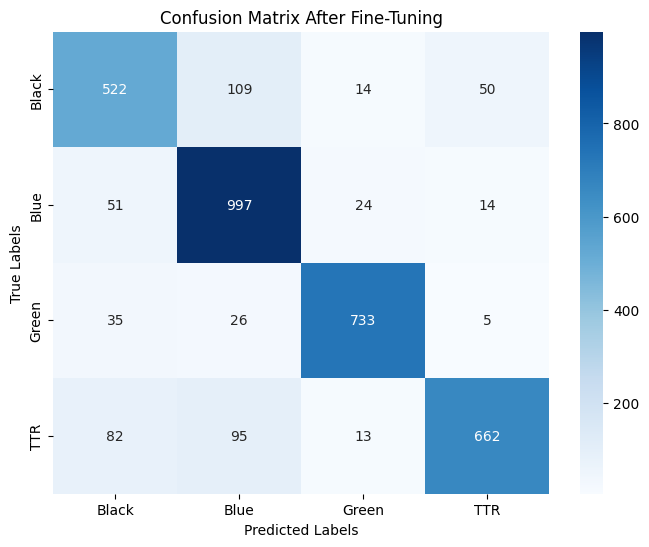

In [7]:
# Calling Everything
main()